_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Cornelius Schröder

Summer term 2020

Due date: 2020-05-26, 9am

Name: Weiyi Xiao:{1,2} Shanqian Ma:{3,4}

# Exercise sheet 5

If needed, download the data files ```nda_ex_5_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

mpl.rc("savefig", dpi=72)

from scipy import signal as signal

import itertools

sns.set_style('whitegrid')
%matplotlib inline


## Load data

In [2]:
spikes = pd.read_csv('../data/nda_ex_5_spiketimes.csv') # neuron id, spike time
stims = pd.read_csv('../data/nda_ex_5_stimulus.csv')  # stimulus onset in ms, direction

stimDur = 2000.    # in ms
nTrials = 11       # number of trials per condition
nDirs = 16         # number of conditions
deltaDir = 22.5    # difference between conditions

stims['StimOffset'] = stims['StimOnset'] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [3]:
# you may add computations as specified above
onsetTime = stims.StimOnset
offsetTime = stims.StimOffset
sp = spikes.SpikeTimes
Dir = np.ones(spikes.shape[0])
Trial = np.zeros(spikes.shape[0]) 
relTime = np.zeros(spikes.shape[0])
stimPeriod = np.zeros(spikes.shape[0])  # 1: during stimulus period, 0: else
trial_count = np.ones(nDirs)
for i in range(len(onsetTime)):
    idx_onset = (sp>onsetTime[i]) & (sp<offsetTime[i])
    idx_trial = (sp>onsetTime[i]-500) & (sp<offsetTime[i]+500)
    # update spikes: condition
    Dir[idx_trial] = stims.Dir[i]
    # update spikes: trial number
    Trial[idx_trial] = trial_count[int(stims.Dir[i]/deltaDir)]
    trial_count[int(stims.Dir[i]/deltaDir)]+=1  # update the trial counter for that direction
    # update spikes: relative time to stimulus onset
    time = sp-onsetTime[i]
    relTime[idx_trial] = time[idx_trial]
    # update spikes: whether it's during stimulus period
    stimPeriod[idx_onset]=1

# add new columns to spikes dataFrame
spikes['Dir'] = Dir
spikes['Trial'] = Trial
spikes['relTime'] = relTime
spikes['stimPeriod'] = stimPeriod


In [4]:
spikes[500:1000]

,Neuron,SpikeTimes,Dir,Trial,relTime,stimPeriod
500,1,15184.233333,270.0,1.0,-385.766667,0.0
501,1,15203.933333,270.0,1.0,-366.066667,0.0
502,1,15311.633333,270.0,1.0,-258.366667,0.0
503,1,15320.500000,270.0,1.0,-249.500000,0.0
504,1,15333.166667,270.0,1.0,-236.833333,0.0
...,...,...,...,...,...,...
995,1,30253.500000,180.0,1.0,822.500000,1.0
996,1,30275.333333,180.0,1.0,844.333333,1.0
997,1,30378.800000,180.0,1.0,947.800000,1.0
998,1,30392.633333,180.0,1.0,961.633333,1.0


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [5]:
def plotRaster(spikes, neuron):
#    Plot spike rasters for a single neuron sorted by condition
#
#    spikes    pandas dataframe with columns 
#                  Neuron
#                  SpikeTimes
#                  Dir
#                  Trial
#                  relTime
#                  stimPeriod
#    neuron    scalar
    nTrials = 11      # number of trials per condition
    nDirs = 16         # number of conditions
    deltaDir = 22.5
    yAxis = np.linspace(0,360,nTrials*nDirs+1)
    plt.figure(figsize=(9, 12))
    for i in range(nTrials*nDirs):
        Dir = int(i/11)*deltaDir
        Trial = i%11 + 1
        x = spikes[(spikes.Neuron==neuron)&(spikes.Dir==Dir)&(spikes.Trial==Trial)].relTime
        plt.vlines(x,yAxis[i],yAxis[i+1],lw=1)
    plt.hlines(361,0,2000,'r')  # Plot a red line indicating stimulus onset.
    plt.xlim([-500,2500])
    plt.ylim([0,365])
    plt.yticks(np.arange(0,360+22.5,22.5))
    plt.xlabel('time relative to stimulus onset (ms)')
    plt.ylabel('direction of motion (degrees)')
    plt.title(f'Raster plot for neuron ${neuron}$')
    plt.show()
    
   
# this function does not return anything, it just creates a plot!

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

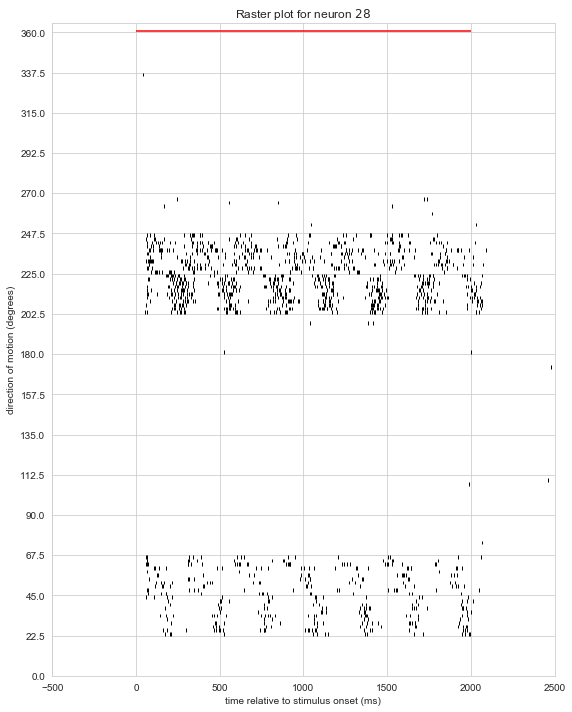

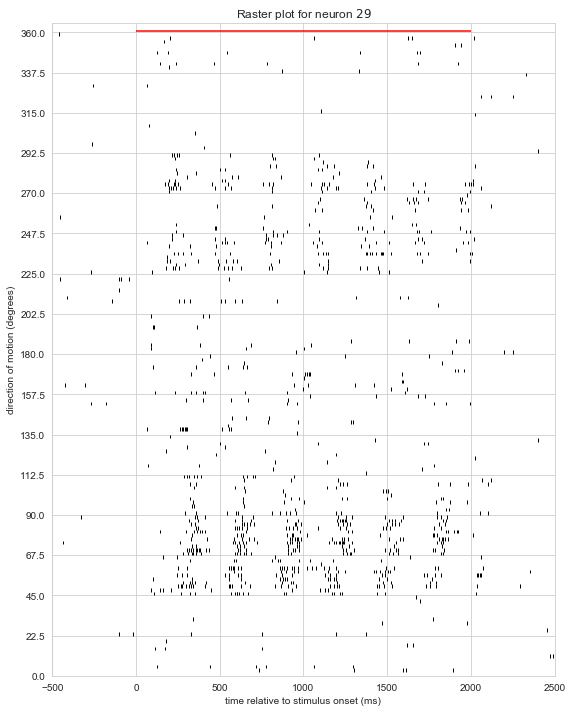

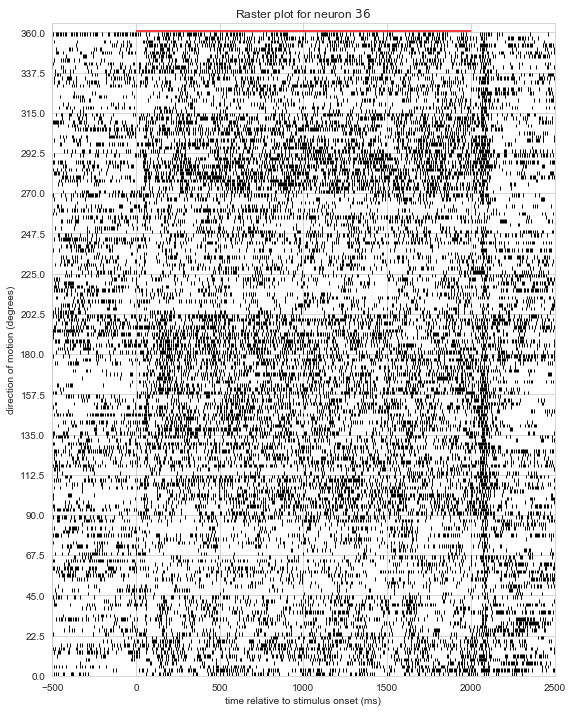

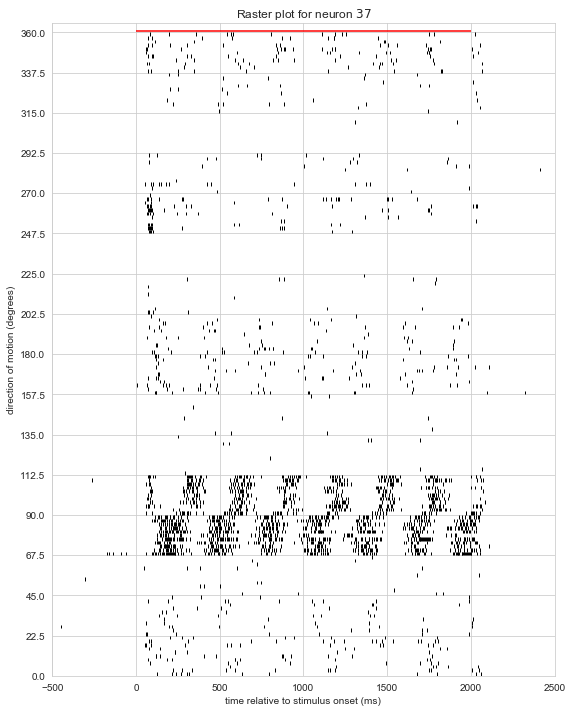

In [6]:
checkList = [28,29,36,37]
for i in checkList:
    plotRaster(spikes,i)

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


In [7]:
def plotPSTH(spikes, neuron):
#    Plot PSTH for a single neuron sorted by condition
#
#    spikes    pandas dataframe with columns 
#                  Neuron
#                  SpikeTimes
#                  Dir
#                  relTime
#                  Trial
#                  stimPeriod
#    neuron    scalar
    nTrials = 11      # number of trials per condition
    nDirs = 16         # number of conditions
    deltaDir = 22.5
    plt.figure(figsize=(9, 12))
    for i in range(nDirs):
        Dir = i*deltaDir
        x = spikes[(spikes.Neuron==neuron)&(spikes.Dir==Dir)&(spikes.Trial>0)].relTime
        bins = np.arange(-500,2500+10,10)  # bin size = 10 ms
        hist,_ = np.histogram(x,bins)
        hist = hist/nTrials
        t = np.arange(-500,2500,10)+5
        plt.plot(t,hist*22.5+i*deltaDir,'-k',lw=1)  # use 22.5 as scaling factor, so the height of each grid(22.5) = 100 spikes/s
    plt.xlim([-500,2500])
    plt.ylim([0,365])
    plt.yticks(np.arange(0,360+22.5,22.5))
    plt.xlabel('time relative to stimulus onset (ms)')
    plt.ylabel('direction of motion (degrees)')
    plt.title(f'Spike density functions for neuron ${neuron}$')
    plt.show()

# this function does not compute anything, just creates a plot

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

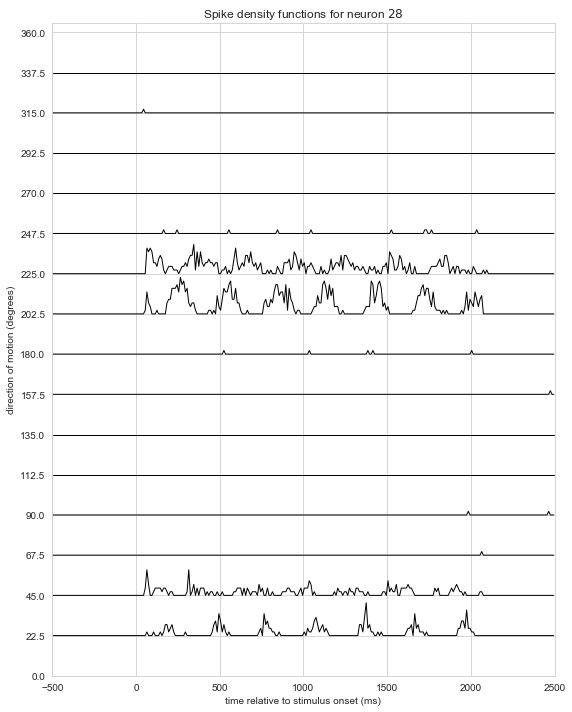

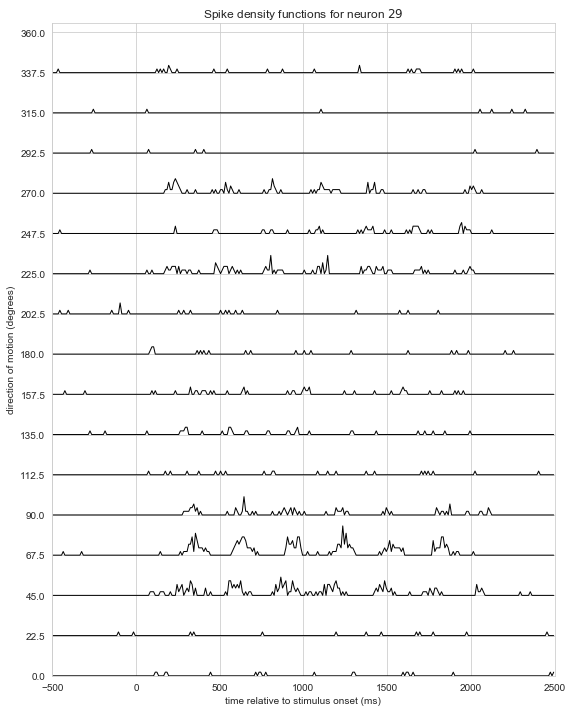

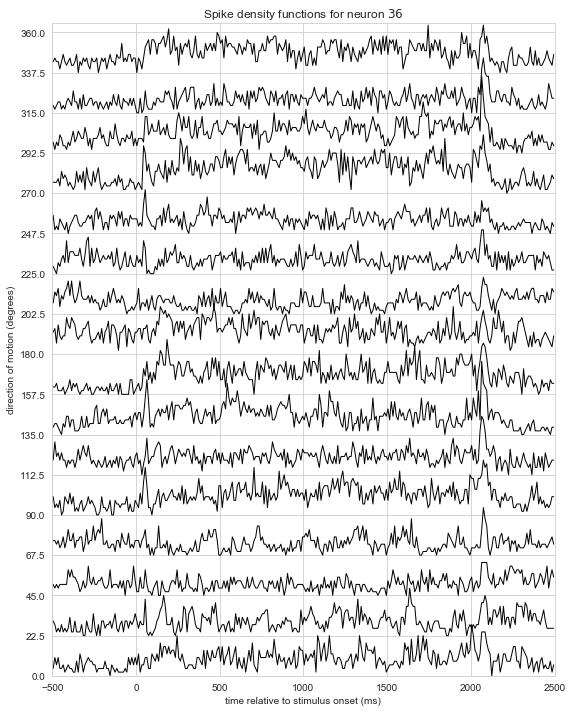

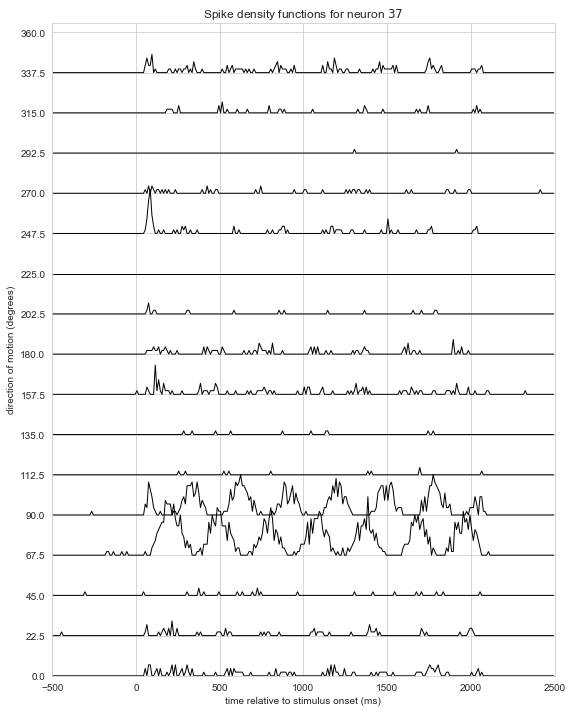

In [8]:
checkList = [28,29,36,37]
for i in checkList:
    plotPSTH(spikes,i)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi)))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [9]:
# to get counts and dirs for each neuron
# X[nth neuron]: row-- ith trial; col-- ith direction
nNeurons=np.shape(spikes.Neuron.unique())[0]
X=np.zeros([nNeurons,nTrials,nDirs])
for i in range(nNeurons):
    for k in range(nDirs):
        for j in range(nTrials):
            Dir = k*deltaDir
            # cnt: spike counts for curretn trial current direction
            cnt=spikes[(spikes.Neuron==i+1)&(spikes.Dir==Dir)&(spikes.Trial==j+1)&(spikes.stimPeriod==1)].count()[1]
            X[i,j,k]=cnt
    #counts=np.array(counts)
    #dirs=np.array(dirs)

dirs=np.arange(0,nDirs)*deltaDir

In [10]:
def vonMises(theta, alpha, kappa, nu, phi):
# Evaluate the parametric von Mises tuning curve with parameters p at locations theta. 
# The locations are given in degrees, not radians.
#
#   theta:  1 by N
#   alpha, kappa, nu, phi:   parameters of the function
#
#   f:      1 by N

    theta=np.deg2rad(theta)

    f=np.exp((alpha+kappa*(np.cos(2*(theta-phi)))-1)+nu*(np.cos(theta-phi)-1))

    return f
    

Plot the von Mises function while varying the parameters systematically.

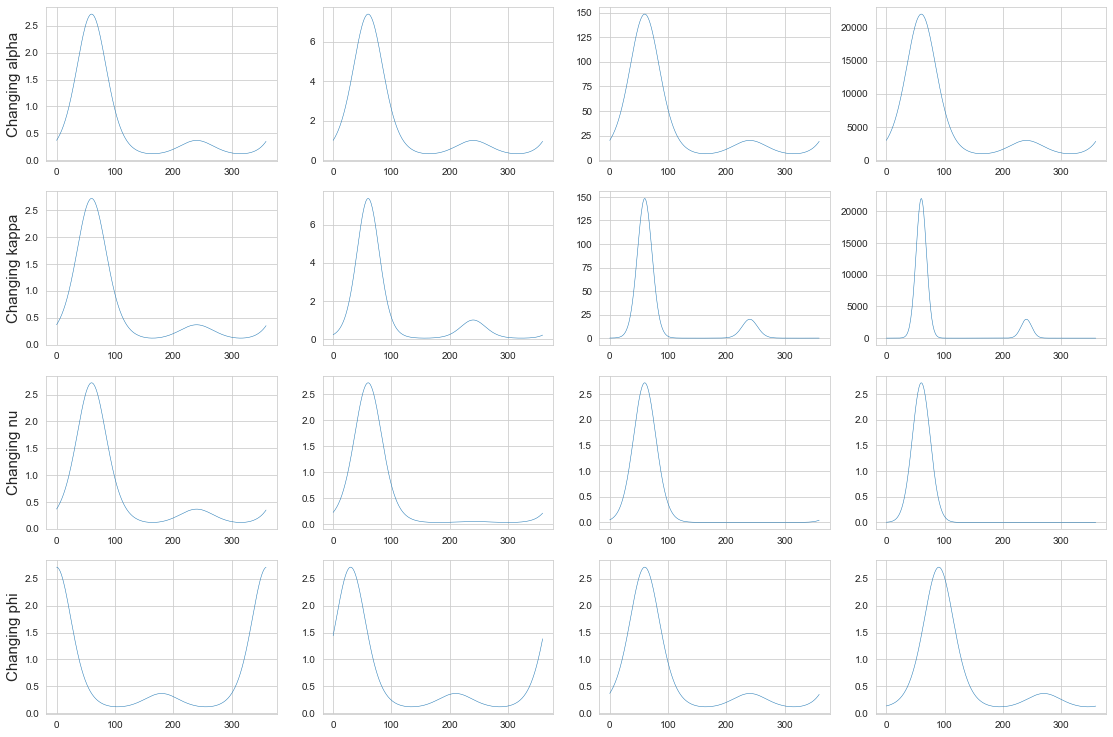

In [11]:
x = np.arange(0,360)

plt.figure(figsize=(19, 13))

#systematically change the parameters
alpha_set=[1,2,5,10]
kappa_set=[1,2,5,10]
nu_set=[1,2,5,10]
phi_set=[0,np.pi/6,np.pi/3,np.pi/2]

#plotting range for angle theta
ndegree=150


for i in range(len(alpha_set)):
    plt.subplot(4,4,i+1)
    plt.plot(x,vonMises(x, alpha_set[i], kappa_set[0], nu_set[0], phi_set[2]),linewidth=.5)
    if i==0: plt.ylabel('Changing alpha',fontsize=15)
for j in range(len(kappa_set)):
    plt.subplot(4,4,i+j+2)
    plt.plot(x,vonMises(x, alpha_set[0], kappa_set[j], nu_set[0], phi_set[2]),linewidth=.5)
    if j==0: plt.ylabel('Changing kappa',fontsize=15)
for k in range(len(nu_set)):
    plt.subplot(4,4,i+j+k+3)
    plt.plot(x,vonMises(x, alpha_set[0], kappa_set[0], nu_set[k], phi_set[2]),linewidth=.5)
    if k==0: plt.ylabel('Changing nu',fontsize=15)
for l in range(len(phi_set)):
    plt.subplot(4,4,i+j+k+l+4)
    plt.plot(x,vonMises(x, alpha_set[0], kappa_set[0], nu_set[0], phi_set[l]),linewidth=.5)
    if l==0: plt.ylabel('Changing phi',fontsize=15)

In [12]:
def tuningCurve(counts, dirs, show):
    '''
    Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.
    Plot the data if show is True, otherwise just return the fit.
        count      #trials x 1, contains the spike count during the stimulation period
        dirs       #trials x 1, contains the direction in degrees
        show       Boolean, indicates whether a plot is generated

        p          1 by 4 parameter vector of tuning curve function
    '''
    ## Here the counts is averaged along every direction, which is different from the counts in Task4
    
    p,pcov=opt.curve_fit(vonMises,dirs,counts)
    
    if show:
        x=np.arange(0,360)
        #plt.plot(dirs,counts,label='average spike counts')
        plt.plot(x,vonMises(x,*p),label='optimal fitting')
        plt.xlabel('direction [degree]',fontsize=15)
        plt.ylabel('spike counts [times]',fontsize=15)
        plt.scatter(dirs,counts,s=15,color='r',label='average spike counts')
        plt.legend()
        return p
    else:
        return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

array([2.05881787, 1.90163264, 0.41176927, 1.0686322 ])

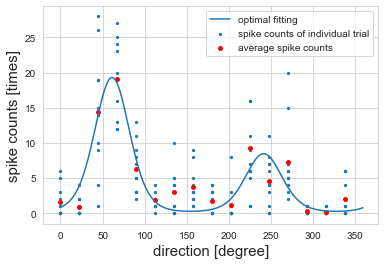

In [13]:
neuron = 29

# more code here
# remind: 
# X_row: ith trial
# X_col: ith direction
counts=X[neuron-1,:,:].mean(axis=0)
plt.scatter(np.tile(dirs,nTrials),X[neuron-1,:,:].flatten(),s=5,label='spike counts of individual trial')
tuningCurve(counts,dirs, True)


array([-1.55587527,  7.33358169,  1.25860578,  1.33130298])

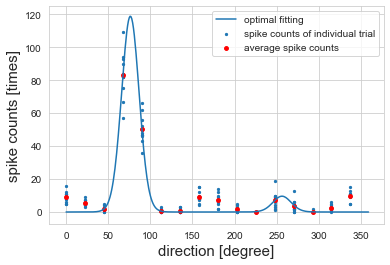

In [14]:
neuron = 37

# more code here
# remind: 
# X_row: ith trial
# X_col: ith direction
counts=X[neuron-1,:,:].mean(axis=0)
plt.scatter(np.tile(dirs,nTrials),X[neuron-1,:,:].flatten(),s=5,label='spike counts of individual trial')
tuningCurve(counts,dirs, True)

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [32]:
def testTuning(dirs, counts, psi=1, show=False):
    """
    Plot the data if show is True, otherwise just return the fit.
        count      #trials x 1, contains the spike count during the stimulation period
        dirs       #trials x 1, contains the direction in degrees
        psi        fourier component to test (1 = direction, 2 = orientation)
        show       Boolean, indicates whether a plot is generated
    
        p       p-value
        q       magnitude of second Fourier component
        qdistr  sampling distribution of |q| under the null hypothesis    

    """
    ## Here the counts is (#trials x #direction)--the response matrix
    '''
    def get_q(di,ct):
        m=[]
        v=[]
        for deg in np.unique(di):
         
            m.append(ct[di==deg].mean()) # get average spike cnt for each direction
            v.append(np.exp(psi*deg*complex(0,1)))
        q_magntd = np.abs(np.array(m) @ np.array(v))
        #print(q_magntd)
        return q_magntd
    '''
    # to get true magnitude
    dirs=np.deg2rad(dirs) #### transfer to radian
    m=counts.mean(axis=0)
    v=np.exp(psi*dirs*complex(0,1))
    q=np.abs(m @ v)
    
    # iterating for shuffled qdistr
    iterations=1000
    qdistr=[] 
    for i in range(iterations):
        shuffle_trial=np.zeros([nTrials,nDirs])
        for j in range(nTrials): # randomize the spike counts for different direction
            shuffle_trial[j,:]=np.random.permutation(counts[j,:])
        m_random=shuffle_trial.mean(axis=0)
        qdistr.append(np.abs(m_random @ v))
        
        
    # fraction of iteration that random q magnitude is larger than real q magnitude    
    qdistr=np.array(qdistr)
    p=len(qdistr[np.where(qdistr>q)[0]])/iterations
    if psi==1: print('For direction tuning')
    if psi==2: print('For orientation tuning')
    print('True magnitude is:', q)
    print('p value is: ',p)
    if show:
        sns.distplot(qdistr, kde=False)
        plt.axvline(q, 0,17,color='r',label='True magnitude')
        plt.xlabel('Magnitude of second Fourier component')
        plt.ylabel('Iteration distribution')
        plt.legend()
        return
    else:
        return p, q, qdistr

  

Show null distribution for the example cell:

For orientation tuning
True magnitude is: 104.25762657685995
p value is:  0.0


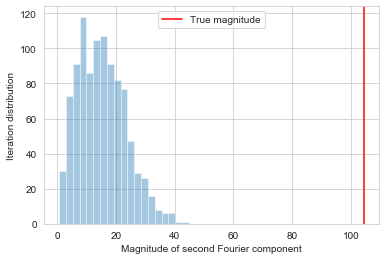

In [33]:
neuron = 28

# more code here
dirs=np.arange(0,nDirs)*deltaDir
counts=X[neuron-1,:,:]

testTuning(dirs,counts,show=True,psi=2)


Test all cells for orientation and direction tuning

In [39]:
nNeurons=np.shape(spikes.Neuron.unique())[0]
p_dir=[]
p_ori=[]
dirs=np.arange(0,nDirs)*deltaDir
for neuron in range(nNeurons):
    counts=X[neuron,:,:]
    print('-------------',neuron+1,'th neuron-------------')
    p_d, q_d, qdistr_d=testTuning(dirs,counts,show=False,psi=1) # direction tuning
    p_o, q_o, qdistr_o=testTuning(dirs,counts,show=False,psi=2) # Orientation tuning
    p_dir.append(p_d)
    p_ori.append(p_o)

------------- 1 th neuron-------------
For direction tuning
True magnitude is: 5.684174614836048
p value is:  0.792
For orientation tuning
True magnitude is: 8.92377947747043
p value is:  0.579
------------- 2 th neuron-------------
For direction tuning
True magnitude is: 13.188313843524245
p value is:  0.47
For orientation tuning
True magnitude is: 69.58495832937928
p value is:  0.0
------------- 3 th neuron-------------
For direction tuning
True magnitude is: 16.61656512284584
p value is:  0.064
For orientation tuning
True magnitude is: 27.711405532139814
p value is:  0.001
------------- 4 th neuron-------------
For direction tuning
True magnitude is: 5.360472236559275
p value is:  0.784
For orientation tuning
True magnitude is: 23.28520342390041
p value is:  0.015
------------- 5 th neuron-------------
For direction tuning
True magnitude is: 5.542746177964648
p value is:  0.015
For orientation tuning
True magnitude is: 4.799005198564259
p value is:  0.053
------------- 6 th neuron--

Number of direction tuned neurons:

In [40]:
np.sum(np.array(p_dir)<0.01)

12

In [41]:
np.where(np.array(p_dir)<0.01) # direction tuning neuron

(array([12, 19, 23, 24, 26, 27, 28, 30, 31, 36, 37, 39], dtype=int64),)

Number of orientation tuned neurons:

In [42]:
np.sum(np.array(p_ori)<0.01)

34

In [43]:
np.where(np.array(p_ori)<0.01) # orientation tuning neuron

(array([ 1,  2,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40],
       dtype=int64),)